
--- Step 4: Exploring Data ---
First glimpse at the data:
   Age  Income  Gender Education         City Likes_McDonalds
0   25   50000    Male  Bachelor     New York             Yes
1   30   60000  Female    Master  Los Angeles              No
2   35   75000    Male       PhD      Chicago             Yes
3   40   90000  Female  Bachelor     New York             Yes
4   45  100000    Male    Master  Los Angeles              No

Data information before cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              10 non-null     int64 
 1   Income           10 non-null     int64 
 2   Gender           10 non-null     object
 3   Education        10 non-null     object
 4   City             10 non-null     object
 5   Likes_McDonalds  10 non-null     object
dtypes: int64(2), object(4)
memory usage: 612.0+ bytes
None

Data informa

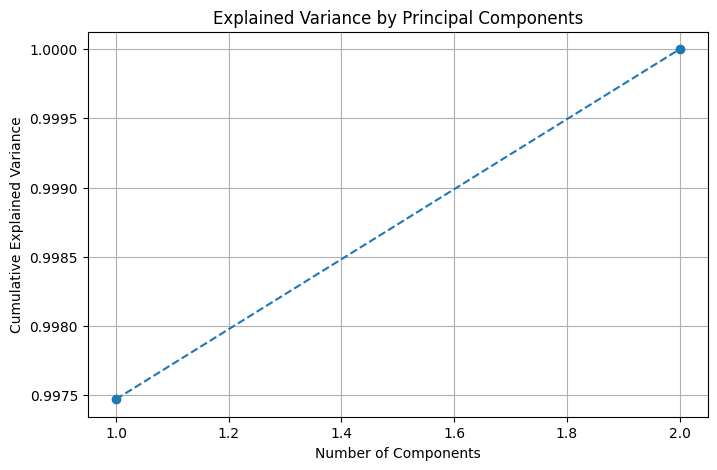

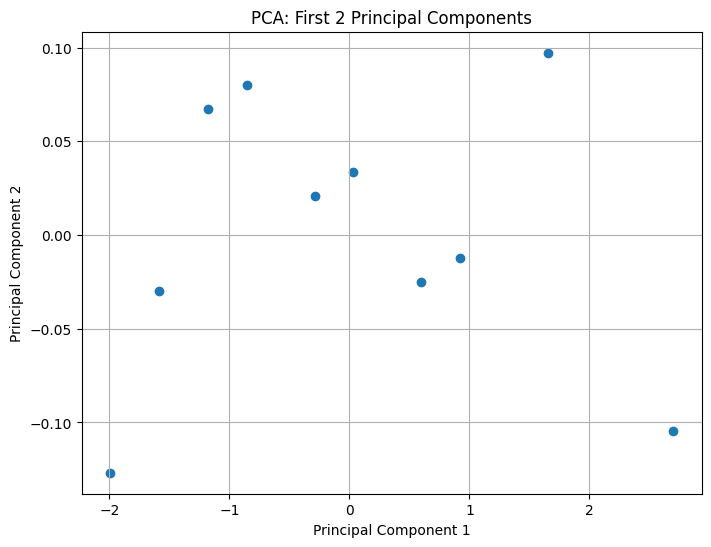


--- Step 5: Extracting Segments ---
Extracting 3 segments using k-means clustering...
Cluster sizes:
Cluster
1    4
2    4
0    2
Name: count, dtype: int64
Silhouette Score: 0.297

--- Step 6: Profiling Segments ---
Segment profiles:
              Age    Income  Gender_Male  Education_Master  Education_PhD  \
Cluster                                                                     
0        1.537022  1.542284          0.5               0.5            0.5   
1       -0.994894 -0.991468          0.5               0.5            0.0   
2        0.226383  0.220326          0.5               0.0            0.5   

         City_Los Angeles  City_New York  Likes_McDonalds_Yes  
Cluster                                                        
0                     0.5            0.0                 0.50  
1                     0.5            0.5                 0.25  
2                     0.0            0.5                 1.00  

Visualizing segment profiles using PCA...


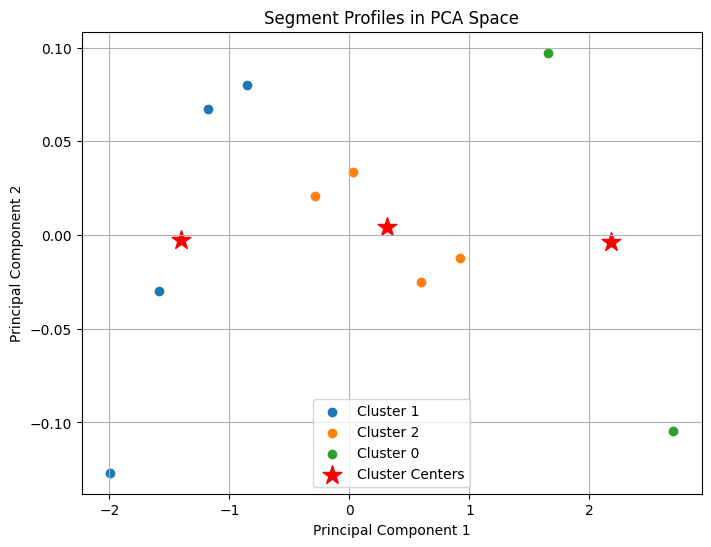

In [6]:

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

# --- Step 4: Exploring Data ---

def explore_data(data):
    """
    Explores the data, performs cleaning, descriptive analysis,
    pre-processing (scaling, handling categorical variables),
    and principal component analysis.

    Args:
        data (pd.DataFrame): The input data.

    Returns:
        pd.DataFrame: The preprocessed data.
        PCA: The PCA object, if performed.
    """
    print("\n--- Step 4: Exploring Data ---")
    print("First glimpse at the data:")
    print(data.head())

    # Data Cleaning (basic example - replace with your specific cleaning needs)
    print("\nData information before cleaning:")
    print(data.info())
    data = data.dropna()  # Drop rows with missing values (example)
    print("\nData information after cleaning:")
    print(data.info())


    # Descriptive Analysis
    print("\nDescriptive statistics:")
    print(data.describe())

    # Pre-processing
    # Categorical Variables (Example: One-Hot Encoding - adjust as needed)
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("\nCategorical columns:", categorical_cols)
        data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
        print("\nData after one-hot encoding:")
        print(data.head())

    # Numeric Variables: Scaling
    numeric_cols = data.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        print("\nNumeric columns:", numeric_cols)
        scaler = StandardScaler()
        data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
        print("\nData after scaling:")
        print(data.head())

    # Principal Components Analysis (PCA)
    pca = None #default
    if len(numeric_cols) > 1: # Perform PCA if there are at least 2 numeric columns
        print("\nPrincipal Components Analysis:")
        pca = PCA()
        pca.fit(data[numeric_cols])
        print("Explained variance ratio:", pca.explained_variance_ratio_)
        # Visualize explained variance
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(numeric_cols) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
        plt.title('Explained Variance by Principal Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid()
        plt.show()

        # Project data to the first 2 principal components for visualization
        data_pca = pca.transform(data[numeric_cols])[:, :2]
        plt.figure(figsize=(8, 6))
        plt.scatter(data_pca[:, 0], data_pca[:, 1])
        plt.title('PCA: First 2 Principal Components')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid()
        plt.show()
    return data, pca


# --- Step 5: Extracting Segments ---

def extract_segments(data, method='kmeans', n_clusters=3, random_state=42):
    """
    Extracts market segments using clustering methods (k-means or Gaussian Mixture Models).

    Args:
        data (pd.DataFrame): The preprocessed data.
        method (str, optional): The clustering method ('kmeans' or 'gmm'). Defaults to 'kmeans'.
        n_clusters (int, optional): The number of clusters. Defaults to 3.
        random_state (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        pd.DataFrame: The data with cluster labels.
        object: The clustering model (KMeans or GaussianMixture).

    Raises:
        ValueError: If an invalid method is specified.
    """
    print("\n--- Step 5: Extracting Segments ---")
    if method == 'kmeans':
        print(f"Extracting {n_clusters} segments using k-means clustering...")
        model = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = model.fit_predict(data)
    elif method == 'gmm':
        print(f"Extracting {n_clusters} segments using Gaussian Mixture Models...")
        model = GaussianMixture(n_components=n_clusters, random_state=random_state)
        cluster_labels = model.fit_predict(data)
    else:
        raise ValueError("Invalid method. Choose 'kmeans' or 'gmm'.")

    segmented_data = data.copy()
    segmented_data['Cluster'] = cluster_labels  # Add cluster labels to the data
    print("Cluster sizes:")
    print(segmented_data['Cluster'].value_counts())

     # Calculate silhouette score
    if len(np.unique(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"Silhouette Score: {silhouette_avg:.3f}")
    else:
        print("Silhouette Score: Not applicable for a single cluster.")
    return segmented_data, model



# --- Step 6: Profiling Segments ---
def profile_segments(segmented_data, pca=None):
    """
    Profiles the extracted segments by analyzing their characteristics.

    Args:
        segmented_data (pd.DataFrame): The data with cluster labels.
        pca (PCA, optional): The PCA object from Step 4, if PCA was performed.
    """
    print("\n--- Step 6: Profiling Segments ---")
    print("Segment profiles:")
    print(segmented_data.groupby('Cluster').mean())

    # Visualizing Segment Profiles (example with first 2 principal components, if available)
    if pca is not None:
        print("\nVisualizing segment profiles using PCA...")
        # Project the cluster centers to the PCA space
        cluster_centers_pca = pca.transform(segmented_data.groupby('Cluster').mean()[numeric_cols])[:, :2]

        # Create a scatter plot of the data with cluster labels
        plt.figure(figsize=(8, 6))
        for cluster_label in segmented_data['Cluster'].unique():
            cluster_data = segmented_data[segmented_data['Cluster'] == cluster_label]
            plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cluster_label}')

        # Plot cluster centers
        plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
                    marker='*', s=200, color='red', label='Cluster Centers')

        plt.title('Segment Profiles in PCA Space')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("\nVisualizing segment profiles using original features...")
        # Create a plot of the data with cluster labels
        plt.figure(figsize=(8, 6))
        for cluster_label in segmented_data['Cluster'].unique():
            cluster_data = segmented_data[segmented_data['Cluster'] == cluster_label]
            plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cluster_label}')
        plt.title('Segment Profiles')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.grid()
        plt.show()

def main():
    """
    Main function to run the market segmentation analysis.
    """
    # Load the data (replace with your actual data loading)
    # Example using a simple DataFrame (replace with your data loading)
    data = pd.DataFrame({
        'Age': [25, 30, 35, 40, 45, 50, 22, 28, 33, 38],
        'Income': [50000, 60000, 75000, 90000, 100000, 120000, 45000, 55000, 70000, 85000],
        'Gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female'],
        'Education': ['Bachelor', 'Master', 'PhD', 'Bachelor', 'Master', 'PhD', 'Bachelor', 'Master', 'PhD', 'Bachelor'],
        'City': ['New York', 'Los Angeles', 'Chicago', 'New York', 'Los Angeles', 'Chicago', 'New York', 'Los Angeles', 'Chicago', 'New York'],
        'Likes_McDonalds': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes']
    })


    # Steps of market segmentation analysis
    processed_data, pca = explore_data(data)
    segmented_data, model = extract_segments(processed_data, method='kmeans', n_clusters=3)  # You can change to 'gmm'
    profile_segments(segmented_data, pca)




import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

# --- Step 4: Exploring Data ---

def explore_data(data):
    """
    Explores the data, performs cleaning, descriptive analysis,
    pre-processing (scaling, handling categorical variables),
    and principal component analysis.

    Args:
        data (pd.DataFrame): The input data.

    Returns:
        pd.DataFrame: The preprocessed data.
        PCA: The PCA object, if performed.
        list: List of numeric column names.
    """
    print("\n--- Step 4: Exploring Data ---")
    print("First glimpse at the data:")
    print(data.head())

    # Data Cleaning (basic example - replace with your specific cleaning needs)
    print("\nData information before cleaning:")
    print(data.info())
    data = data.dropna()  # Drop rows with missing values (example)
    print("\nData information after cleaning:")
    print(data.info())


    # Descriptive Analysis
    print("\nDescriptive statistics:")
    print(data.describe())

    # Pre-processing
    # Categorical Variables (Example: One-Hot Encoding - adjust as needed)
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("\nCategorical columns:", categorical_cols)
        data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
        print("\nData after one-hot encoding:")
        print(data.head())

    # Numeric Variables: Scaling
    numeric_cols = data.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        print("\nNumeric columns:", numeric_cols)
        scaler = StandardScaler()
        data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
        print("\nData after scaling:")
        print(data.head())

    # Principal Components Analysis (PCA)
    pca = None #default
    if len(numeric_cols) > 1: # Perform PCA if there are at least 2 numeric columns
        print("\nPrincipal Components Analysis:")
        pca = PCA()
        pca.fit(data[numeric_cols])
        print("Explained variance ratio:", pca.explained_variance_ratio_)
        # Visualize explained variance
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(numeric_cols) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
        plt.title('Explained Variance by Principal Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid()
        plt.show()

        # Project data to the first 2 principal components for visualization
        data_pca = pca.transform(data[numeric_cols])[:, :2]
        plt.figure(figsize=(8, 6))
        plt.scatter(data_pca[:, 0], data_pca[:, 1])
        plt.title('PCA: First 2 Principal Components')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid()
        plt.show()
    return data, pca, list(numeric_cols)


# --- Step 5: Extracting Segments ---

def extract_segments(data, method='kmeans', n_clusters=3, random_state=42):
    """
    Extracts market segments using clustering methods (k-means or Gaussian Mixture Models).

    Args:
        data (pd.DataFrame): The preprocessed data.
        method (str, optional): The clustering method ('kmeans' or 'gmm'). Defaults to 'kmeans'.
        n_clusters (int, optional): The number of clusters. Defaults to 3.
        random_state (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        pd.DataFrame: The data with cluster labels.
        object: The clustering model (KMeans or GaussianMixture).

    Raises:
        ValueError: If an invalid method is specified.
    """
    print("\n--- Step 5: Extracting Segments ---")
    if method == 'kmeans':
        print(f"Extracting {n_clusters} segments using k-means clustering...")
        model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10) # Added n_init
        cluster_labels = model.fit_predict(data)
    elif method == 'gmm':
        print(f"Extracting {n_clusters} segments using Gaussian Mixture Models...")
        model = GaussianMixture(n_components=n_clusters, random_state=random_state)
        cluster_labels = model.fit_predict(data)
    else:
        raise ValueError("Invalid method. Choose 'kmeans' or 'gmm'.")

    segmented_data = data.copy()
    segmented_data['Cluster'] = cluster_labels  # Add cluster labels to the data
    print("Cluster sizes:")
    print(segmented_data['Cluster'].value_counts())

     # Calculate silhouette score
    if len(np.unique(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"Silhouette Score: {silhouette_avg:.3f}")
    else:
        print("Silhouette Score: Not applicable for a single cluster.")
    return segmented_data, model



# --- Step 6: Profiling Segments ---
def profile_segments(segmented_data, pca=None, numeric_cols=None):
    """
    Profiles the extracted segments by analyzing their characteristics.

    Args:
        segmented_data (pd.DataFrame): The data with cluster labels.
        pca (PCA, optional): The PCA object from Step 4, if PCA was performed.
        numeric_cols (list, optional): List of numeric column names.
    """
    print("\n--- Step 6: Profiling Segments ---")
    print("Segment profiles:")
    print(segmented_data.groupby('Cluster').mean())

    # Visualizing Segment Profiles (example with first 2 principal components, if available)
    if pca is not None and numeric_cols is not None:
        print("\nVisualizing segment profiles using PCA...")
        # Project the cluster centers to the PCA space
        cluster_centers_pca = pca.transform(segmented_data.groupby('Cluster').mean()[numeric_cols])[:, :2]

        # Create a scatter plot of the data with cluster labels
        plt.figure(figsize=(8, 6))
        for cluster_label in segmented_data['Cluster'].unique():
            cluster_data = segmented_data[segmented_data['Cluster'] == cluster_label]
            # Ensure we only plot numeric columns or the first two PCA components if available
            if pca is not None and cluster_data.shape[1] > 1:
                 cluster_data_pca = pca.transform(cluster_data[numeric_cols])[:, :2]
                 plt.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1], label=f'Cluster {cluster_label}')
            elif cluster_data.shape[1] > 1:
                 plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cluster_label}')


        # Plot cluster centers
        plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
                    marker='*', s=200, color='red', label='Cluster Centers')

        plt.title('Segment Profiles in PCA Space')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("\nVisualizing segment profiles using original features...")
        # Create a plot of the data with cluster labels
        plt.figure(figsize=(8, 6))
        # Ensure there are at least 2 features to plot
        if segmented_data.shape[1] >= 3: # At least 2 features + Cluster column
            for cluster_label in segmented_data['Cluster'].unique():
                cluster_data = segmented_data[segmented_data['Cluster'] == cluster_label]
                # Assuming the first two columns after index are features
                plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cluster_label}')
            plt.title('Segment Profiles')
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            plt.legend()
            plt.grid()
            plt.show()
        else:
            print("Not enough features to plot segment profiles using original features.")


def main():
    """
    Main function to run the market segmentation analysis.
    """
    # Load the data (replace with your actual data loading)
    # Example using a simple DataFrame (replace with your data loading)
    data = pd.DataFrame({
        'Age': [25, 30, 35, 40, 45, 50, 22, 28, 33, 38],
        'Income': [50000, 60000, 75000, 90000, 100000, 120000, 45000, 55000, 70000, 85000],
        'Gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female'],
        'Education': ['Bachelor', 'Master', 'PhD', 'Bachelor', 'Master', 'PhD', 'Bachelor', 'Master', 'PhD', 'Bachelor'],
        'City': ['New York', 'Los Angeles', 'Chicago', 'New York', 'Los Angeles', 'Chicago', 'New York', 'Los Angeles', 'Chicago', 'New York'],
        'Likes_McDonalds': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes']
    })


    # Steps of market segmentation analysis
    processed_data, pca, numeric_cols = explore_data(data.copy()) # Pass a copy to avoid modifying the original data unexpectedly
    segmented_data, model = extract_segments(processed_data.copy(), method='kmeans', n_clusters=3)  # Pass a copy
    profile_segments(segmented_data, pca, numeric_cols)



if __name__ == "__main__":
    main()